# Analysis of Density inside the Core

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import re,glob,os
from scipy import integrate
from numpy import pi as π
import dgutils
from pimcscripts import pimchelp
from collections import defaultdict
from scipy import interpolate
from dgutils import colors as colortools
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.transforms as mtransforms

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# plot style
plot_style = {'aps':'../include/aps.mplstyle', 'notebook':'../include/notebook.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['notebook'])

figsize = plt.rcParams['figure.figsize']

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ρ_col = [colors[0],colors[1],colors[2],colors[3],colors[6],colors[8]]
grey = '#4B4B4B'

import hg_utils
from hg_utils import lab as lab

## Simulation Parameters

In [2]:
ΔR = [0.0,2.0,3.0,4.0]
T = 2.0
w = 3.0
L = 100
sim_params = {'T':T,'canonical':False,'μ':-7.2, 'L':L, 'τ':0.004}

## We load the merged (individual seeds) QMC data for the core density from the data directory

In [3]:
ρ_1d_seeds = {}

for cΔR in ΔR:
    dir_name = f'{hg_utils.base_dir(cΔR,cylinder=True,raw=False)}'

    # find the appropriate linedensity file and extract the value and headers
    fname = dir_name + os.sep + pimchelp.get_file_list_from_params(**sim_params,base_dir=dir_name,ftype='linedensity')
    headers = pimchelp.getHeadersFromFile(fname)
    x = np.array([float(cx) for cx in headers]) - L/2
    ρ_1d_seeds[lab(cΔR)] = np.loadtxt(fname)
    print(f'ΔR = {cΔR}:  {ρ_1d_seeds[lab(cΔR)].shape}')

ΔR = 0.0:  (200, 200)
ΔR = 2.0:  (100, 200)
ΔR = 3.0:  (205, 200)
ΔR = 4.0:  (151, 200)


## Load the averaged values

In [26]:
reduce_params = {'reduce':'T', 'L':100, 'μ':-7.2}

ρ_1d_qmc = {}
for cΔR in [0]+ΔR:
    ρ_1d_qmc[lab(cΔR)] = pimchelp.PIMCResults(pimchelp.get_reduce_name(**reduce_params, base_dir=hg_utils.base_dir(cΔR,raw=False),
                                                                       estimator='linedensity'))
    reduce_par = ρ_1d_qmc[lab(cΔR)].params[0]
    
start = int(len(x)/2)
end = len(x)

idx_pos = range(start,end-1)
idx_neg = range(start-1,0,-1)

ρ̄_1d = {}
Δρ̄_1d = {}
for cΔR in [0]+ΔR:
    _x,_ρ,_Δρ =  ρ_1d_qmc[lab(cΔR)].epdata(reduce_par)
    
    ρ̄_1d[lab(cΔR)] = np.copy(_ρ)

    ρ̄_1d[lab(cΔR)][idx_neg] = 0.5*(_ρ[idx_pos] + _ρ[idx_neg])
    ρ̄_1d[lab(cΔR)][idx_pos] = 0.5*(_ρ[idx_pos] + _ρ[idx_neg])
    
    Δρ̄_1d[lab(cΔR)] = np.copy(_Δρ)
    Δρ̄_1d[lab(cΔR)][idx_neg] = 0.5*np.sqrt(_Δρ[idx_pos]**2 + _Δρ[idx_neg]**2) 
    Δρ̄_1d[lab(cΔR)][idx_pos] = 0.5*np.sqrt(_Δρ[idx_pos]**2 + _Δρ[idx_neg]**2)

## Exploit the mirror symmetry around $x=0$

In [34]:
start = int(len(x)/2)
end = len(x)

idx_pos = range(start,end-1)
idx_neg = range(start-1,0,-1)

for cΔR in ΔR:
    _ρ = np.copy(ρ_1d_seeds[lab(cΔR)])
    
    ρ_1d_seeds[lab(cΔR)][:,idx_neg] = 0.5*(_ρ[:,idx_pos] + _ρ[:,idx_neg])
    ρ_1d_seeds[lab(cΔR)][:,idx_pos] = 0.5*(_ρ[:,idx_pos] + _ρ[:,idx_neg])

## Compute the Average Density by integrating in the tails ($L-2w$)

In [4]:
ρₒ_seeds = {}
x_mask_out_right = np.where(x > L/2-1*w)[0]

for cΔR in ΔR:
    ρₒ_seeds[lab(cΔR)] = integrate.simpson(ρ_1d_seeds[lab(cΔR)][:,x_mask_out_right],x=x[x_mask_out_right],axis=1)/(x[x_mask_out_right[-1]] - x[x_mask_out_right[0]])


0.253325172736755 0.004028431367809174


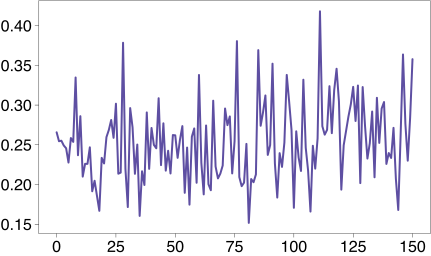

In [5]:
cΔR = 4.0
plt.plot(ρₒ_seeds[lab(cΔR)])
ave = np.average(ρₒ_seeds[lab(cΔR)])
std = np.std(ρₒ_seeds[lab(cΔR)])/np.sqrt(len(ρₒ_seeds[lab(cΔR)])-1)
print(ave,std)

In [77]:
def plot_ρ_1d(_ax,_x,_ρ,_Δρ,idxs,cΔR,_col,label='_nolegend_', line=True, shift=False, ave_ρ=0.0, Δave_ρ=0.0, alpha='80'):
    
    if shift:
        _ρ,_Δρ = shifted_ave(_ρ,_Δρ,ave_ρ, Δave_ρ)
    
    if line:
        _ax.plot(x[:],_ρ[:], ls='-', lw=0.25, color=_col)
    
    _ax.errorbar(x[:],_ρ[:],yerr=_Δρ[:], **plot_params(_col, alpha=alpha), label=label)
    return _ax

In [90]:
def plot_params(color, eb=True, alpha='80'):

    alpha_f = int(alpha,16)/255.0
    _p = {'marker':'o', 'linewidth':0.1, 'color':color, 
          'markerfacecolor':colortools.get_alpha_hex(color,alpha_f)+alpha, 'markersize':2, 
          'markeredgecolor':color, 'linestyle':':', 'markeredgewidth':0.5}
    if eb:
        _p['ecolor'] = color
        _p['elinewidth'] = 0.5
        _p['linestyle'] = 'None'
        _p['barsabove'] = True

    return _p

TeX  NOT subset; don't know how to subset; dropped
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


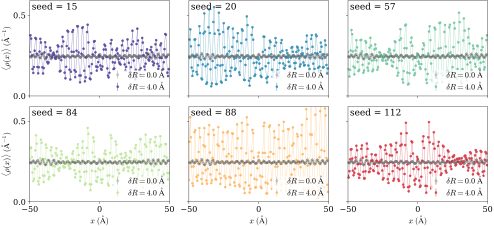

In [107]:
seed=117

cΔR = 4.0

with plt.style.context(plot_style['aps']):
    figsize = plt.rcParams['figure.figsize']
    fig,axes = plt.subplots(nrows=2,ncols=3,sharex=True, sharey=True, figsize=(2*figsize[0],1.5*figsize[1]),constrained_layout=True)
    trans = mtransforms.ScaledTranslation(2/72, -2/72, fig.dpi_scale_trans)
    
    seed = np.sort(np.random.randint(low=0, high=ρ_1d_seeds[lab(cΔR)].shape[0],size=6))
    for i, ax in enumerate(axes.flat):
        plot_ρ_1d(ax,*ρ_1d_qmc[lab(0.0)].epdata(reduce_par),range(0,1),cΔR,grey+'80', alpha='11', label=r'$\delta R = 0.0\; {\rm \AA}$')
        
        plot_ρ_1d(ax,x,ρ_1d_seeds[lab(cΔR)][seed[i],:],np.zeros_like(x),range(0,ρ_1d_seeds[lab(cΔR)].shape[1]),
                  cΔR,ρ_col[i], alpha='FF', label=r'$\delta R = 4.0\; {\rm \AA}$')  
        
        
        ax.text(0.0, 1.0, f'seed = {seed[i]}', transform=ax.transAxes + trans, ha='left', va='top')
        ax.legend(loc='lower right', facecolor='w',framealpha=0.8, frameon=True, edgecolor='None', borderpad=0.1)
        ax.set_xlim(-50,50)
        ax.set_ylim(0,0.59)
        
    for cax in axes[-1,:]:
        cax.set_xlabel(r'$x\; (\rm \AA)$')
    for cax in axes[:,0]:
        cax.set_ylabel(r'$\langle \rho(x) \rangle\; (\rm \AA^{-1})$')
        
    plt.savefig('../figures/rho_vs_x_seeds.pdf')

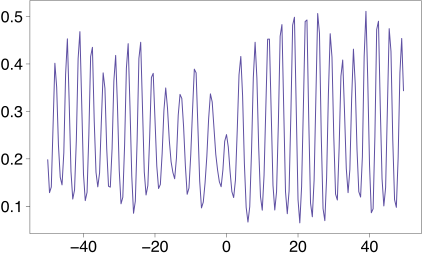

In [89]:
seed=117
plt.plot(x,ρ_1d_seeds[lab(cΔR)][seed,:], ls='-', lw=1)

In [15]:
cΔR = 4.0

for seed in range(ρ_1d_seeds[lab(cΔR)].shape[0]):
    plt.plot(x,ρ_1d_seeds[lab(cΔR)][seed,:], ls='None', marker='.')

In [ ]:
from scipy.signal import argrelmax,argrelmin

ρ_max_arg = defaultdict(list)
ρ_min_arg = defaultdict(list)

for cΔR in ΔR:
        
    # don't use mirror symmetry
    _x,_ρ,_Δρ = ρ_1d_qmc[lab(cΔR)].epdata(reduce_par) 
    
    # use mirror symmetry
    _x,_ρ,_Δρ = x,ρ̄_1d[lab(cΔR)],Δρ̄_1d[lab(cΔR)]
    
    idxs = list(range(x_mask_in[0]+1)) + list(range(x_mask_in[-1]+1,len(x)))
    max_arg = argrelmax(_ρ)[0]
    min_arg = argrelmin(_ρ)[0]
    
    x_cut_indices = x_mask_in
    
    ρ_max_arg[lab(cΔR)] = [carg for carg in max_arg if carg not in x_cut_indices]
    ρ_min_arg[lab(cΔR)] = [carg for carg in min_arg if carg not in x_cut_indices]

In [ ]:
ρₒ_ave = {}
Δρₒ_ave = {}

for cΔR in ΔR:

    tρₒ = []
    _x,_ρ,_Δρ =  ρ_1d_qmc[lab(cΔR)].epdata(reduce_par) 

    # first average max-to-max
    for num_peaks in range(1,5):
        neg_max_start,neg_max_end = ρ_max_arg[lab(cΔR)][1],ρ_max_arg[lab(cΔR)][num_peaks+1]
        pos_max_start,pos_max_end = ρ_max_arg[lab(cΔR)][-1-num_peaks],ρ_max_arg[lab(cΔR)][-1]
        tρₒ.append(np.average(
            np.hstack((_ρ[neg_max_start:neg_max_end+1],_ρ[pos_max_start:pos_max_end+1]))))
        
    # then min-to-min
    for num_troughs in range(1,5):
        neg_min_start,neg_min_end = ρ_min_arg[lab(cΔR)][1],ρ_min_arg[lab(cΔR)][num_troughs+1]
        pos_min_start,pos_min_end = ρ_min_arg[lab(cΔR)][-1-num_troughs],ρ_min_arg[lab(cΔR)][-1]
        tρₒ.append(np.average(
            np.hstack((_ρ[neg_min_start:neg_min_end+1],_ρ[pos_min_start:pos_min_end+1]))))
        
    ρₒ_ave[lab(cΔR)] = np.average(tρₒ)
    Δρₒ_ave[lab(cΔR)] = np.std(tρₒ)

with plt.style.context(plot_style['notebook']):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(nrows=1,ncols=1,sharex=True, sharey=True, figsize=(figsize[0],figsize[1]))

    _x,_ρ,_Δρ =  ρ_1d_qmc[lab(cΔR)].epdata(reduce_par) 
    
    ax.plot(x[neg_max_start:neg_max_end+1],_ρ[neg_max_start:neg_max_end+1],'-ko')
    ax.plot(x[pos_max_start:pos_max_end+1],_ρ[pos_max_start:pos_max_end+1],'-ko')
    
    ax.axhline(y=ρₒ_qmc[lab(cΔR)], label='QMC')
    
    for i,ct in enumerate(tρₒ):
        ax.axhline(y=ct, color=colors[i+1], label=f'{ct:8.6f}')
    ax.legend()